# Coursework for Cardiac MR Image Segmentation (2021-2022)

##Introduction
Cardiovascular disease is a condition that occurs when blood vessels clot in the heart, leading to heart attacks and even death in certain severe cases. The World Health Organisation estimated around 17 million people losing their lives because of this cardiovascular disease. There have been significant advances in vessel analysis in the past few decades, including identifying and treating diseases of internal organs and reducing heart disease mortality. MRI, computerized tomography (CT), and ultrasound are several more popular medical imaging techniques that provide advanced qualitative and quantitative assessments of internal organ anatomical structures and functions in determining diagnosis, disease observation, and treatment decisions. Using the manual approach of analyzing the volume of chambers could be prone to subjective error that costs a life. In recent years, major advances have been made in cardiovascular research and practice aiming to improve the diagnosis and treatment of cardiac diseases and reduce the mortality of CVD. Modern medical imaging techniques, such as magnetic resonance imaging (MRI), computed tomography (CT), and ultrasound are now widely used, which enable non-invasive qualitative and quantitative assessment of cardiac anatomical structures and functions and provide support for diagnosis, disease monitoring, treatment planning, and prognosis. Of particular interest, cardiac image segmentation is a primary step in numerous applications. Based on the semantics of the image, it partitions an image into various quantitative measurements, such as the volume of the left ventricle (LV), the right ventricle (RV), and the mass of the myocardium (MY). This project aims at image segmentation of a cardiovascular Magnetic resonance using advanced image segmentation models in Deep learning. Heart image segmentation typically involves the left atrium, right atrium, left ventricle, and coronary arteries. The data for this project was taken from the ACDC1 challenge and further pre-processed by the module lead of the neural computing coursework. It contains 200 Cardiovascular images with the truth mask in the png format. The data split into 50% for training, 10% for validation, and 40% for testing. For the training set, there are 100 CMR images and 100 respective ground truth mask images. Cuda is one of the parallel computing platforms and programming models used to speed up the compute intensity. Using PyTorch Cuda a track of the currently selected GPU, and all CUDA tensors allocated will by default be created on the selected device. An open-source computer vision library was used to import the dataset, convert it to grayscale, and plot the image data using matplotlib python library.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device  :',device)

device  : cuda


## Reading an Image with its corresponding mask

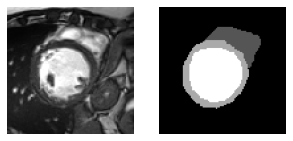

(96, 96)


In [3]:
import os
import cv2 #import OpenCVfrom matplotlib import pyplot as plt
import matplotlib.pyplot as plt


def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

data_dir = '/content/drive/MyDrive/data/train/'

image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)

show_image_mask(image, mask, cmap='gray')
plt.pause(1)
#cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)
print(image.shape)

### Loading definitions of Train and Test Datasets

In [4]:
import torch
import torch.utils.data as data
import cv2
import os
from glob import glob

path = '/content/drive/MyDrive/data/train'


class TrainDataset(data.Dataset):
    def __init__(self, root=path):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        #print(self.img_files)
        self.mask_files = []
        #print(self.img_files)
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()    #tensor vlaues for data( image) and label( mask) is returned.

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(),img_path              #Returning the image path for further use

    def __len__(self):
        return len(self.img_files)

### Segmentation Models Below
Model Architecture, Model to Device, Model Summary

UNET Modified Final Model,

Based on the analysis we came to we included the batch Normalisation layer between conv2d and activaiton layer in each blok. It was significantly observed that the model has higher stability now 

In [5]:
#Model Architecture, Model to Device, Model Summary Single Pre-Conv

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
def double_conv(in_channels, out_channels, mid_channels = None):
    if not mid_channels:
            mid_channels = out_channels
    return nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
    )   

class UNet_Modified2(nn.Module):

    def __init__(self, n_class=4):
        super().__init__()
        
  
        self.dconv_down1 = double_conv(1, 64, 3) 
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512) 
       #self.dconv_down5 = double_conv(512, 1024)       

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):


        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

        #https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

model_UNET2 = UNet_Modified2() # We can now create a model using your defined segmentation model
model_UNET2 = model_UNET2.to(device)
print(model_UNET2)
summary(model_UNET2,input_size=(1,96,96),batch_size=4)

UNet_Modified2(
  (dconv_down1): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, moment

### Basic Transfer Learning Model Approach 1: First pretrained model used is RESNET50 encoder with IMAGENET weights

In [6]:
#Run this to install, import and use Pytorch default Segmentation models
!pip install segmentation_models_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 4.7 MB/s 
     |████████████████████████████████| 376 kB 15.2 MB/s 
     |████████████████████████████████| 58 kB 7.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=74a003582649c30b0fad33c4a6953798b54867434e813377c7a853f8a51196ca
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=4ea28368071a2bf455f0cb1f081158046ad46b433d6c39648f4806e6532582cb
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [7]:
import segmentation_models_pytorch as smp

model_resnet50 = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)
model_resnet50

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

#Experimentation


### Model Training + Validation in single function:
We have created a single function to train and validate the models over the epochs. The function returns a trained model which can be saved and deployed for future predictions on test data. We are also plotting the train loss and validation loss over epochs, providing useful insights about training and validation.

In [9]:
from torch.utils.data import DataLoader
from collections import defaultdict
import time
import argparse
import torch.nn.functional as F
import torch.nn as nn

import torch.optim as optim
from torch.optim import lr_scheduler

val_data_path = '/content/drive/MyDrive/data/val'
data_path = '/content/drive/MyDrive/data/val'

num_workers = 4
batch_size = 4
epoch_train_losses=[]
epoch_val_losses = []
val_set = TrainDataset(val_data_path)  #Change
val_data_loader = DataLoader(dataset=val_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)
train_set = TrainDataset(data_path)
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)

def plot_losses(epoch_train_losses, epoch_val_losses): 
  plt.plot(epoch_train_losses, 'b-',label='Taining Losses')
  plt.plot(epoch_val_losses, color='orange',label='Validation Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Error')
  plt.legend()
  plt.show()


def train_and_validate(model,
              device,
              optimizer,
              epochs: int =10,
              batch_size: int = 1,
              learning_rate: float = 3e-4,
              criterion = nn.CrossEntropyLoss(),
):
  if isinstance(criterion,torch.nn.Module): ##just to be sure that criterion is on the correct device.
    criterion.to(device)
  for epoch in range(epochs) :
    #torch.set_grad_enabled(True)
    since = time.time() 
    train_loss = 0.0
    model.train()
    for iteration, sample in enumerate(training_data_loader):
        img, mask = sample
        img=img.unsqueeze(1)
        img  = img.to(device = device)
        #https://discuss.pytorch.org/t/only-batches-of-spatial-targets-supported-non-empty-3d-tensors-but-got-targets-of-size-1-1-256-256/49134/18 
        mask = mask.squeeze(1)
        mask = mask.to(device,dtype = torch.long)      
        out  = model(img)
        #print(out.shape)
        optimizer.zero_grad()
        scheduler = lr_scheduler.StepLR(optimizer,step_size=30,gamma=0.1),
        #dice_loss = dice_coef_binary_loss(mask,out)
        #dice= dice_loss(F.softmax(out, dim=1).float(), F.one_hot(mask, 4).permute(0, 3, 1, 2).float(),multiclass=True)
        #loss = dice

    # Then write your BACKWARD & OPTIMIZE below
    # Note: Compute Loss and Optimize
        loss = criterion (out,mask) 
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

     #   print('train loss',loss.item(),' step :',global_step,' epoch :',epoch)
    
    val_loss =0.0
    model.eval()
    for image,mask in val_data_loader:
      #print(image.shape,mask.shape)
      image = image.to(device)
      image = image.unsqueeze(1)
      mask = mask.to(device,dtype = torch.long)

      out = model(image)
      loss = criterion(out,mask.long())
      val_loss += loss.item() * image.size(0)
      out_np = torch.max(out,1).indices.cpu().detach().numpy()

    epoch_train_losses.append(train_loss / len(train_set))
    epoch_val_losses.append(val_loss/len(val_set))
    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_set)} \t\t Validation Loss: {val_loss / len(val_set)}')
  plot_losses(epoch_train_losses, epoch_val_losses)
  return model

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


###Training our adapted UNET2
 We initially used RMSProp as the optimiser along with Cross entropy loss function. Learning rate chosen experimentally as 0.00001. Different combiantions were tried to increase the performance.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 		 Training Loss: 0.3486256778240204 		 Validation Loss: 1.4366498708724975
Epoch 2 		 Training Loss: 0.3068773329257965 		 Validation Loss: 1.4362756490707398
Epoch 3 		 Training Loss: 0.28235033750534055 		 Validation Loss: 1.3804444789886474
Epoch 4 		 Training Loss: 0.2600737392902374 		 Validation Loss: 1.2784873485565185
Epoch 5 		 Training Loss: 0.24190413057804108 		 Validation Loss: 1.1641191959381103
Epoch 6 		 Training Loss: 0.22820904552936555 		 Validation Loss: 1.0477118492126465
Epoch 7 		 Training Loss: 0.21680594980716705 		 Validation Loss: 0.9450084805488587
Epoch 8 		 Training Loss: 0.20616883635520936 		 Validation Loss: 0.8644357204437256
Epoch 9 		 Training Loss: 0.19927738904953002 		 Validation Loss: 0.8108397722244263
Epoch 10 		 Training Loss: 0.19557771682739258 		 Validation Loss: 0.7698518633842468
Epoch 11 		 Training Loss: 0.18798172175884248 		 Validation Loss: 0.738638961315155
Epoch 12 		 Training Loss: 0.18268083930015563 		 Validation Loss: 

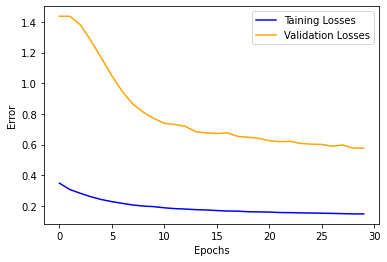

In [10]:
#Training with Final UNET model with Optimiser as RMS PROP, passed directly as arguments.
lr_rate = 0.000001
batch_size = 4
model = model_UNET2
learned_model = train_and_validate(model ,device, optim.RMSprop(model.parameters(), lr=lr_rate, weight_decay=1e-8, momentum=0.9), 30, batch_size,  learning_rate=lr_rate)

We can see that there was no convergence occuring when we are using RMS prop optimiser. Hence we use Adam optimiser.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 		 Training Loss: 0.20829552114009858 		 Validation Loss: 5.096342706680298
Epoch 2 		 Training Loss: 0.17452656030654906 		 Validation Loss: 19.376082801818846
Epoch 3 		 Training Loss: 0.15045143961906432 		 Validation Loss: 5.519488000869751
Epoch 4 		 Training Loss: 0.13388151824474334 		 Validation Loss: 1.1417820930480957
Epoch 5 		 Training Loss: 0.12472997605800629 		 Validation Loss: 0.48910887241363527
Epoch 6 		 Training Loss: 0.11634455770254135 		 Validation Loss: 0.4947002649307251
Epoch 7 		 Training Loss: 0.10878394991159439 		 Validation Loss: 0.44799235463142395
Epoch 8 		 Training Loss: 0.1029209017753601 		 Validation Loss: 0.37965003252029417
Epoch 9 		 Training Loss: 0.09689903706312179 		 Validation Loss: 0.35465188026428224
Epoch 10 		 Training Loss: 0.09036238044500351 		 Validation Loss: 0.3463219165802002
Epoch 11 		 Training Loss: 0.08498038798570633 		 Validation Loss: 0.3383880376815796
Epoch 12 		 Training Loss: 0.08393736481666565 		 Validation L

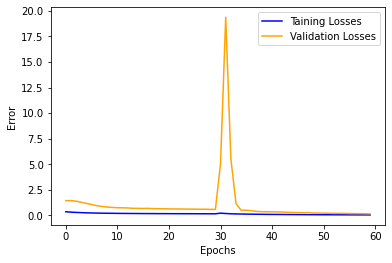

In [11]:
lr_rate = 3e-4
batch_size = 4
model = model_UNET2
learned_model = train_and_validate(model ,device, optim.Adam(model.parameters(),lr = lr_rate), 30, batch_size,  learning_rate=lr_rate)

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr149.png


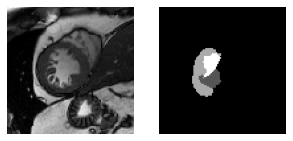

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr179.png


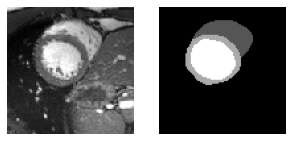

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr186.png


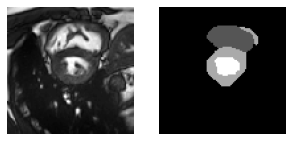

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr133.png


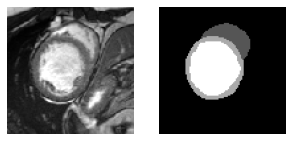

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr125.png


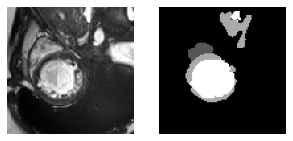

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr137.png


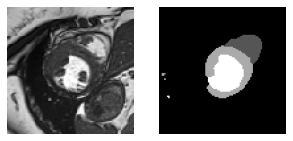

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr196.png


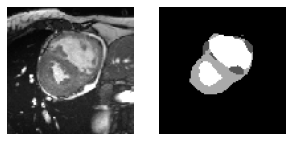

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr148.png


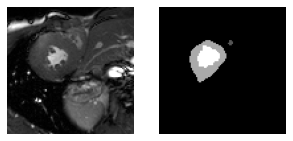

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr132.png


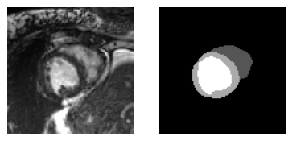

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr123.png


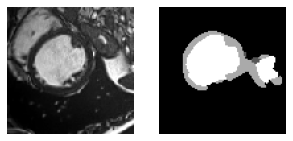

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr124.png


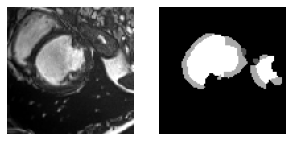

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr122.png


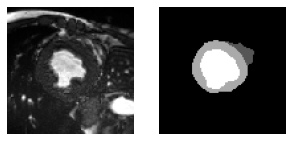

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr173.png


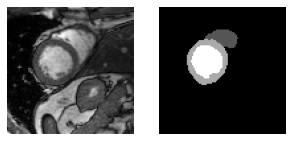

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr164.png


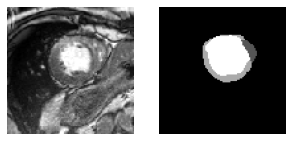

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr177.png


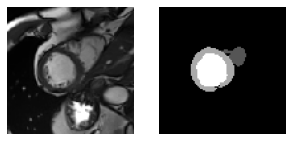

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr152.png


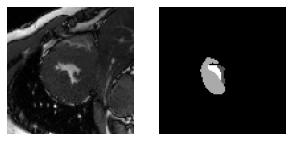

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr194.png


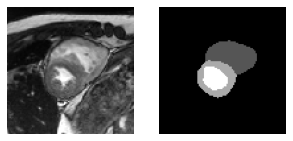

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr193.png


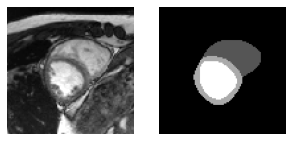

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr190.png


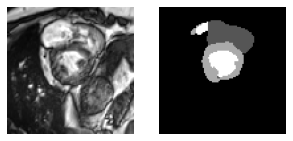

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr168.png


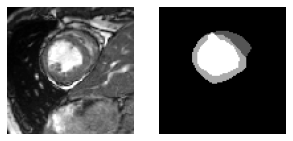

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr153.png


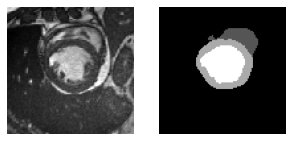

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr129.png


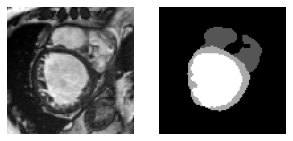

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr198.png


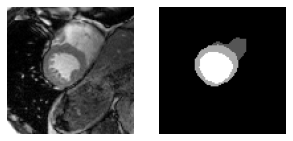

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr155.png


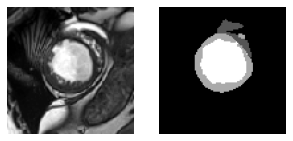

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr170.png


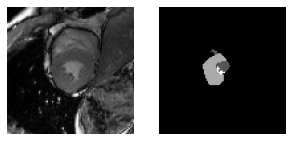

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr139.png


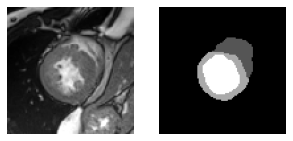

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr197.png


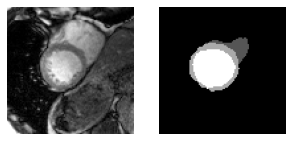

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr183.png


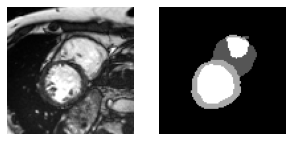

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr172.png


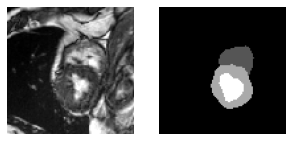

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr145.png


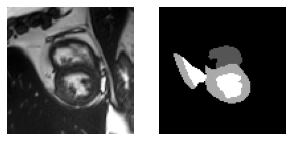

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr162.png


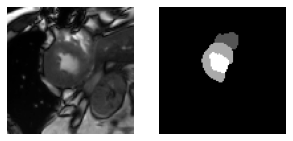

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr178.png


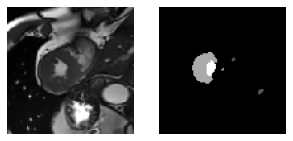

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr142.png


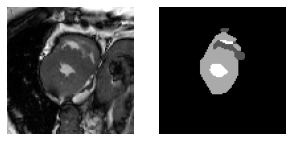

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr154.png


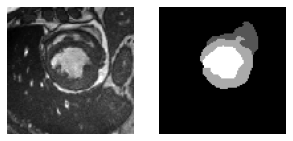

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr200.png


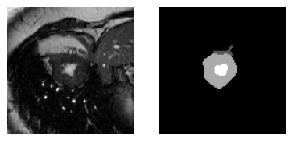

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr188.png


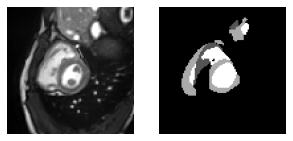

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr127.png


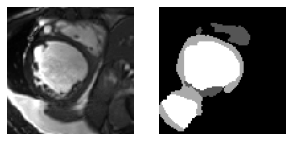

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr174.png


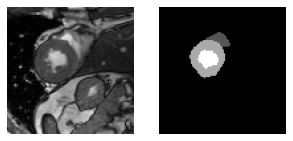

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr176.png


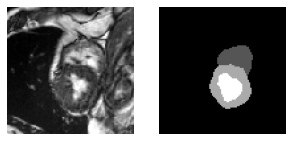

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr135.png


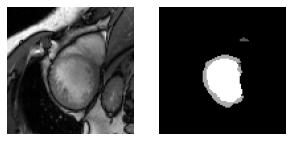

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr161.png


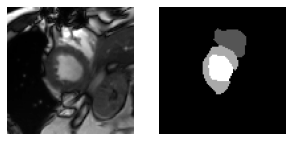

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr167.png


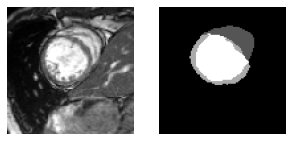

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr166.png


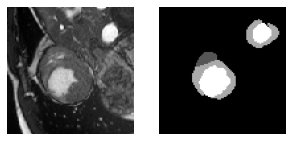

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr184.png


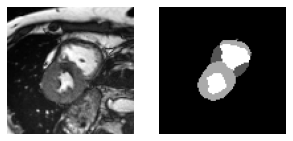

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr128.png


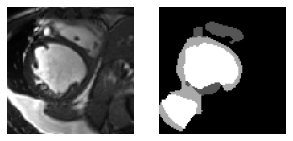

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr182.png


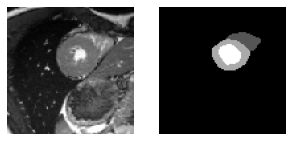

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr192.png


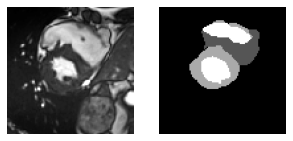

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr143.png


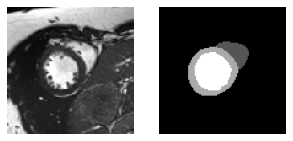

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr150.png


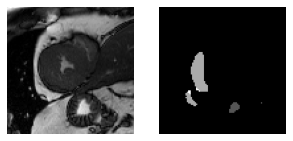

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr130.png


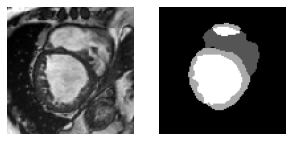

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr121.png


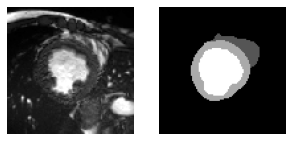

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr141.png


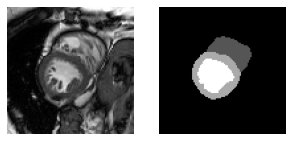

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr138.png


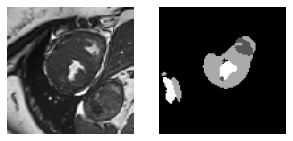

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr160.png


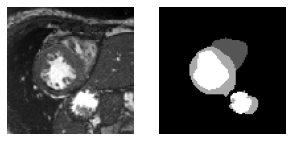

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr171.png


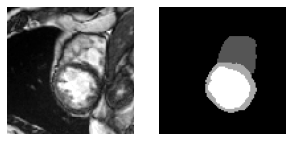

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr144.png


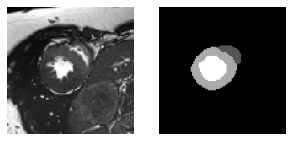

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr185.png


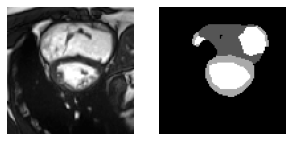

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr165.png


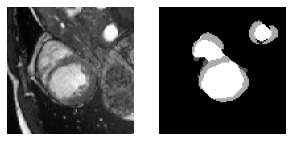

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr126.png


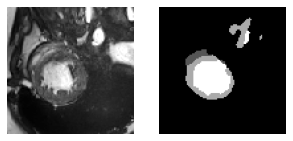

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr199.png


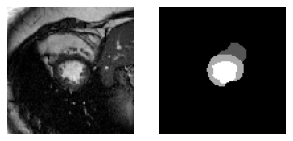

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr147.png


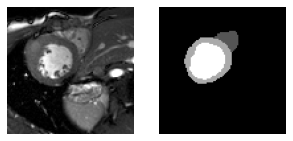

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr151.png


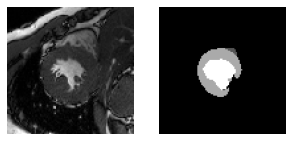

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr180.png


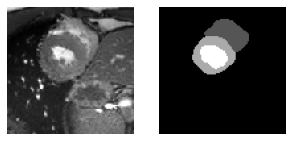

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr175.png


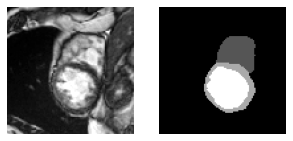

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr191.png


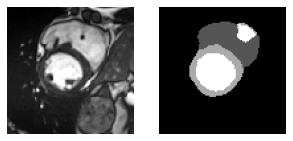

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr169.png


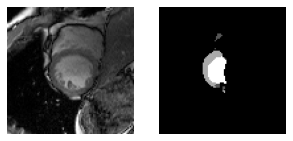

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr189.png


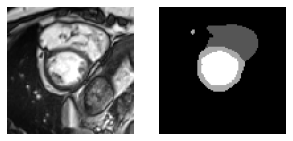

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr134.png


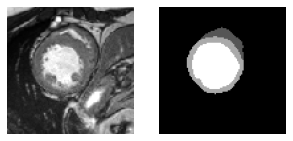

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr157.png


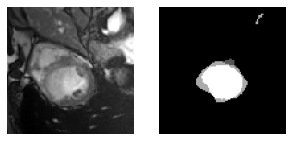

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr187.png


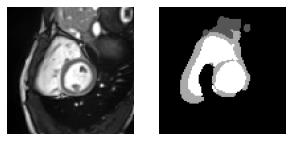

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr136.png


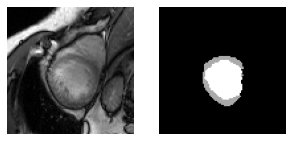

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr181.png


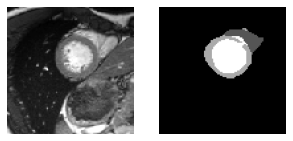

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr163.png


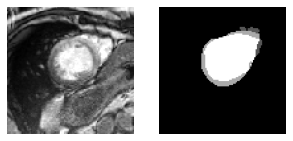

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr195.png


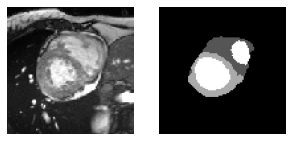

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr131.png


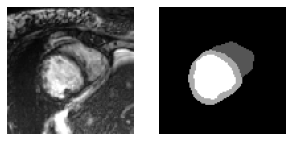

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr159.png


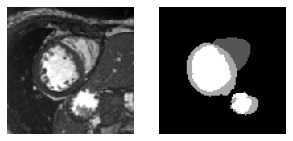

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr158.png


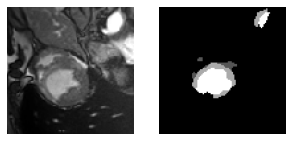

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr146.png


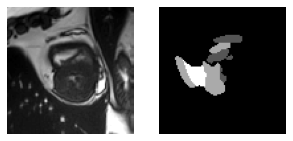

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr156.png


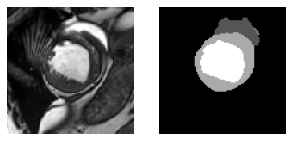

torch.Size([1, 96, 96])
torch.Size([1, 1, 96, 96])
/content/drive/MyDrive/data/test/image/cmr140.png


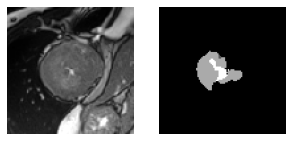

In [12]:
 #In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
import re
from torchvision.utils import save_image
data_path = '/content/drive/MyDrive/data/test/'
num_workers = 2
batch_size = 1
Learned_model= model
test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)
Learned_model.eval()
for iteration, sample in enumerate(test_data_loader):
    img,img_pth = sample
    #print(img.shape)
    print(img.size())
    img = img.unsqueeze(1)
    print(img.size())
    img = img.to(device)
    out = Learned_model(img)
    out_np = torch.max(out,1).indices.cpu().detach().numpy()
    image_np = img.cpu().detach().numpy()
    print(img_pth[0])
   # print(re.split(r'\/',img_pth[0]))
    #img_pth = re.split(r'\/',img_pth[0])
    #print(img_pth)
    #path = os.path.join('',img_pth[-1])
    #print(path)  
    #path=path[:6]
    #print(path)
    #cv2.imwrite('/mask/' + path, out)
    dir_to_save = '/content/mask_UNET/'
    for i in range(1):
            show_image_mask(image_np[i,0], out_np[i], cmap='gray')
            plt.pause(1)
            image_name = img_pth[i].split('/')[-1].split('.')[0]+'_mask.png'
            #print(image_name,os.path.join(output_test_mask_path,image_name))
            cv2.imwrite(os.path.join(dir_to_save,image_name),out_np[0])

## Transfer Learning with Data Augmentation, Modified EfficientNet B4

###Augmentation of dataset to generate new data and appropriate modification of Dataloaders for Transfer Learning

In [13]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="efficientnet-b4",        # choose encoder,
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=4,                      # model output channels (number of classes in your dataset)
)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

In [14]:
from matplotlib import pyplot as plt
def show_image_mask_mask(img, mask,out, cmap='gray'): # function shows image and 2 masks 
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 3, 1,label='image')
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    
    plt.subplot(1, 3, 2,label='mask')
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 3, 3,label='predicted mask')
    plt.imshow(out, cmap=cmap)
    plt.axis('off')

def show_image_mask(img, mask, cmap='gray'): # known function that shows an image and a mask
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

In [17]:
from torch.utils.data import DataLoader
import torch,numpy as np
import torch.utils.data as data
import cv2
import os
from glob import glob
import albumentations as A

transform = A.Compose([
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5,border_mode=1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
    
])

class TrainDatasetModified(data.Dataset):
    def __init__(self, root=''):
        super(TrainDatasetModified, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            global transform
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            transformed =  transform(image=data,mask=label)
            return torch.from_numpy(np.expand_dims(transformed['image'],axis=0)).float(), torch.from_numpy(transformed['mask']).float()

    def __len__(self):
        return len(self.img_files)
    
    
class ValDatasetModified(data.Dataset):
    def __init__(self, root=''):
        super(ValDatasetModified, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        self.mask_files = []
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            global transform
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            
            return torch.from_numpy(np.expand_dims(data,axis=0)).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)
    
class TestDatasetModified(data.Dataset):
    def __init__(self, root=''):
        super(TestDatasetModified, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = np.expand_dims(cv2.imread(img_path, cv2.IMREAD_UNCHANGED), axis=0)
            return torch.from_numpy(data).float() , img_path

    def __len__(self):
        return len(self.img_files)

In [18]:
import time
model.to(device)

data_path = '/content/drive/MyDrive/data/train/'
num_workers = 4
batch_size = 5
train_set = TrainDatasetModified(data_path)  #Using augmented training set
training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True) 

#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = smp.losses.DiceLoss('multiclass', classes=None, log_loss=True, from_logits=True, smooth=0.0, ignore_index=None, eps=1e-07)   #using multiclass dice loss instead of cross entropy
train_loss=[]
model.train()
#opt_sgd = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
opt = torch.optim.Adam(model.parameters(), lr=0.0008)
for epoch in range(60):  # loop over the dataset 

    running_loss = 0.0
    for image,mask in training_data_loader:
        
        image.to(device)
        mask.to(device)
        image = image.to(device)
        mask = mask.to(device)
        out = model(image)
        loss = loss_fn(out,mask.long())
        opt.zero_grad()
        loss.backward()
        opt.step()
        running_loss += (loss.item()/batch_size)
        
    train_loss.append(running_loss)
    print('Train loss for epoch:',epoch,' : ',train_loss)
    if epoch%10 == 0:
        torch.save(model,'u-effb4_chckpnt.pth')
    
        

torch.save(model,'u-effb4.pth')
print('Finished Training. model saved')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss for epoch: 0  :  [6.123011970520021]
Train loss for epoch: 1  :  [6.123011970520021, 3.6289260149002076]
Train loss for epoch: 2  :  [6.123011970520021, 3.6289260149002076, 2.24378387928009]
Train loss for epoch: 3  :  [6.123011970520021, 3.6289260149002076, 2.24378387928009, 1.1647204399108886]
Train loss for epoch: 4  :  [6.123011970520021, 3.6289260149002076, 2.24378387928009, 1.1647204399108886, 0.7947873294353484]
Train loss for epoch: 5  :  [6.123011970520021, 3.6289260149002076, 2.24378387928009, 1.1647204399108886, 0.7947873294353484, 0.6487353175878525]
Train loss for epoch: 6  :  [6.123011970520021, 3.6289260149002076, 2.24378387928009, 1.1647204399108886, 0.7947873294353484, 0.6487353175878525, 0.6245679408311844]
Train loss for epoch: 7  :  [6.123011970520021, 3.6289260149002076, 2.24378387928009, 1.1647204399108886, 0.7947873294353484, 0.6487353175878525, 0.6245679408311844, 0.6038737460970879]
Train loss for epoch: 8  :  [6.123011970520021, 3.6289260149002076, 

In [19]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

The current device is cuda:0



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


CrossEntropy loss score for image :  0.09411147981882095


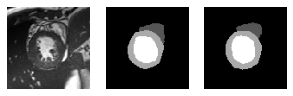

CrossEntropy loss score for image :  0.23878642916679382


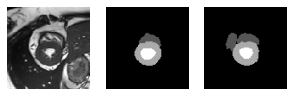

CrossEntropy loss score for image :  0.13742654025554657


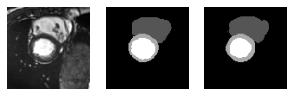

CrossEntropy loss score for image :  0.069424107670784


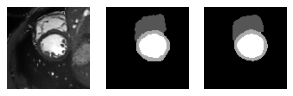

CrossEntropy loss score for image :  0.08187752217054367


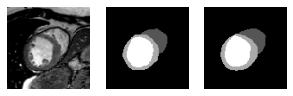

CrossEntropy loss score for image :  0.0763024091720581


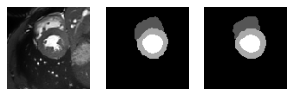

CrossEntropy loss score for image :  0.13922196626663208


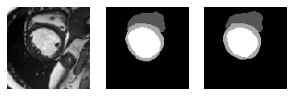

CrossEntropy loss score for image :  0.12330415844917297


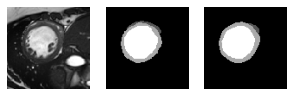

CrossEntropy loss score for image :  0.06402601301670074


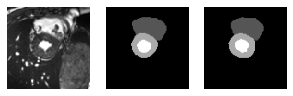

CrossEntropy loss score for image :  0.1832323968410492


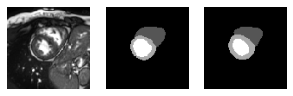

CrossEntropy loss score for image :  0.07229231297969818


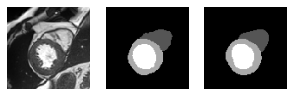

CrossEntropy loss score for image :  0.12166735529899597


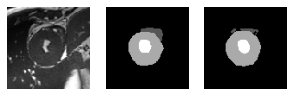

CrossEntropy loss score for image :  0.12317575514316559


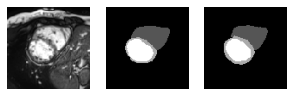

CrossEntropy loss score for image :  0.2172725945711136


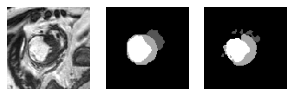

CrossEntropy loss score for image :  0.14815831184387207


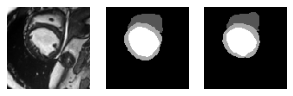

CrossEntropy loss score for image :  0.0619712732732296


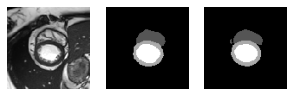

CrossEntropy loss score for image :  0.13306860625743866


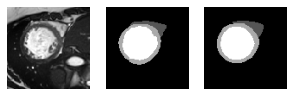

CrossEntropy loss score for image :  0.20913931727409363


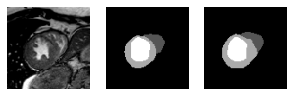

CrossEntropy loss score for image :  0.14020520448684692


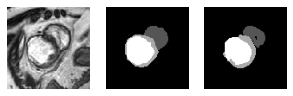

CrossEntropy loss score for image :  0.09557832032442093


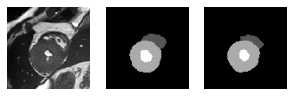

Val_score :  0.8786522627344269


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")
#model=torch.load('unet-res50_opt_3.pth')
#model.to(device)
loss_fn = torch.nn.CrossEntropyLoss()

num_workers = 4
batch_size = 1
data_path='/content/drive/MyDrive/data/val/'
val_set = ValDatasetModified(data_path)
training_data_loader = DataLoader(dataset=val_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
print('')
model.eval()
total_val_score=0
for image,mask in training_data_loader:
        #print(image.shape,mask.shape)
        image = image.to(device)
        mask = mask.to(device)
        out = model(image)
        loss = loss_fn(out,mask.long())
        print('CrossEntropy loss score for image : ',loss.item())
        
        out_np = torch.max(out,1).indices.cpu().detach().numpy()
        mask_np = mask.cpu().detach().numpy()
        image_np = image.cpu().detach().numpy()
        #print(out_np[0].shape,mask_np.shape)
        d_score=0
        for j in range(1,4):
            d_score += categorical_dice(mask_np[0], out_np[0],j)
        total_val_score += d_score/3
        for i in range(1):
            show_image_mask_mask(image_np[i,0],mask_np[i], out_np[i], cmap='gray')
            plt.pause(1)
print("Val_score : ",total_val_score/20)

The current device is cuda:0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


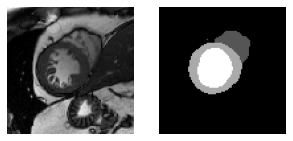

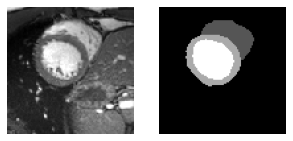

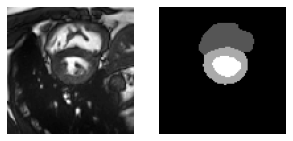

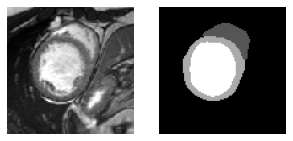

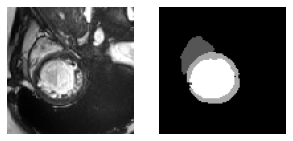

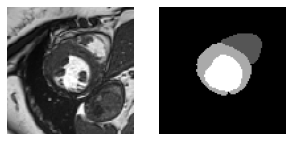

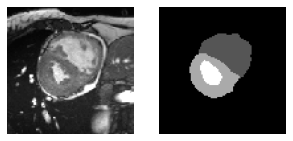

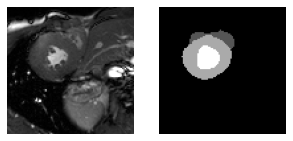

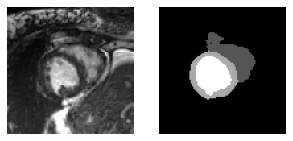

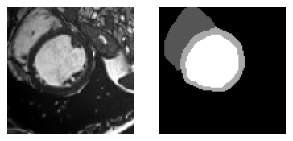

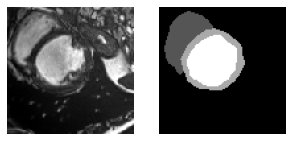

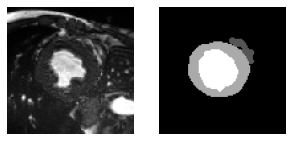

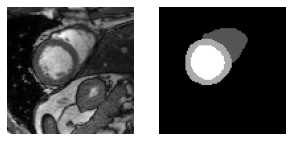

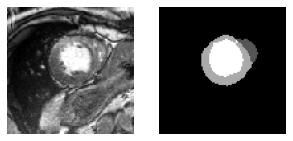

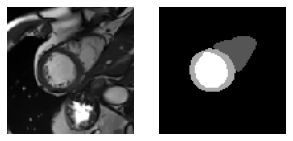

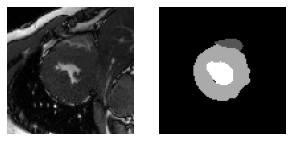

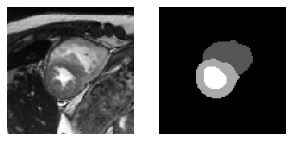

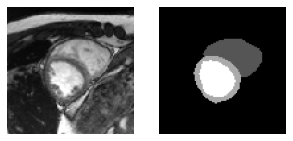

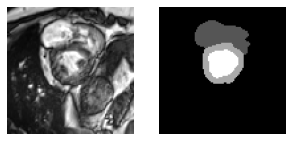

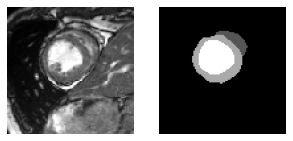

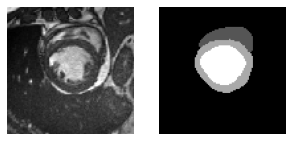

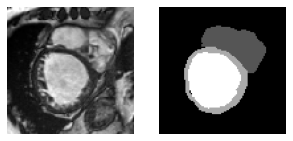

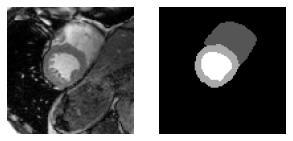

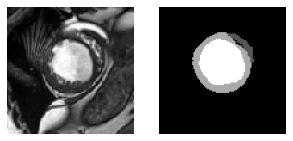

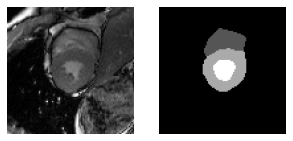

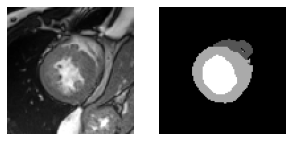

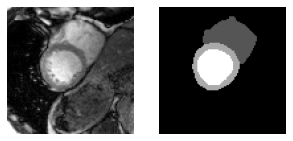

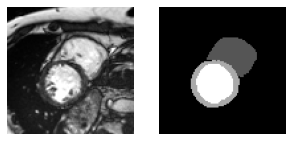

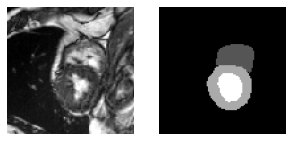

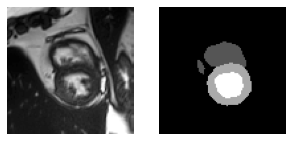

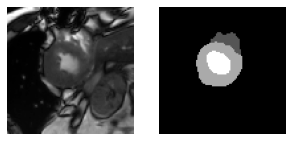

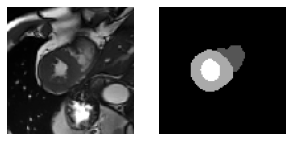

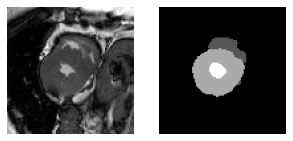

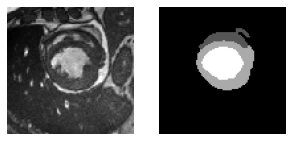

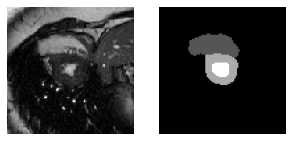

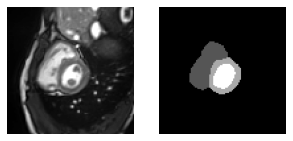

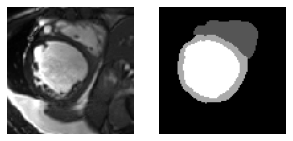

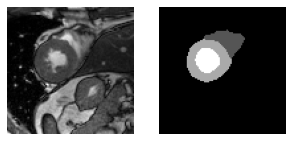

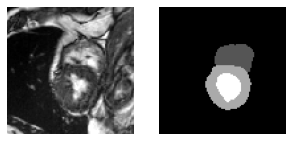

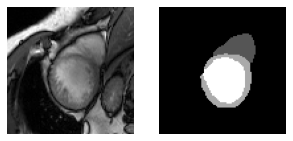

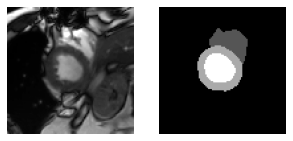

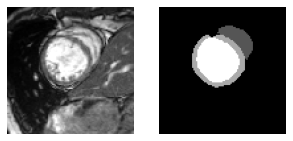

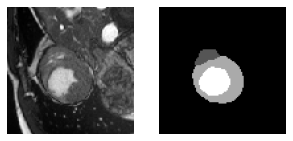

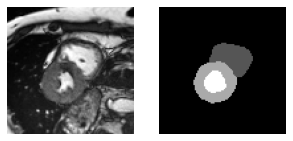

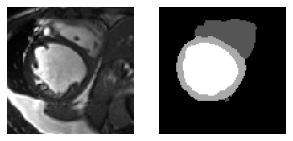

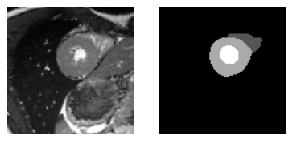

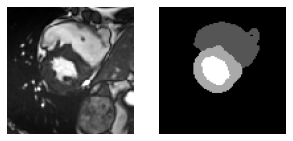

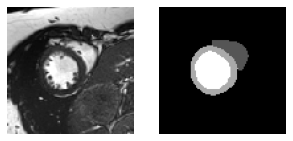

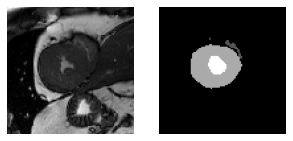

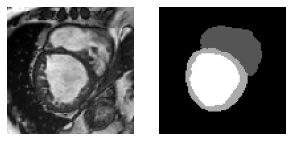

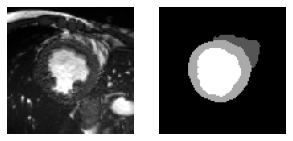

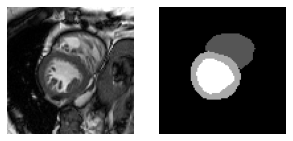

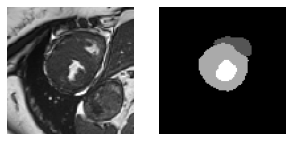

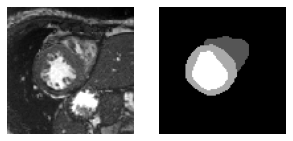

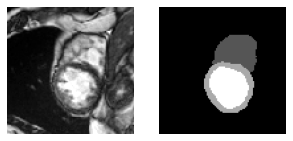

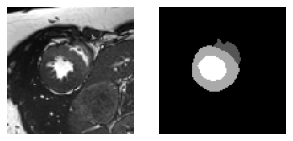

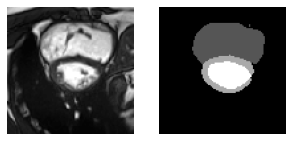

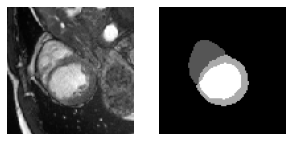

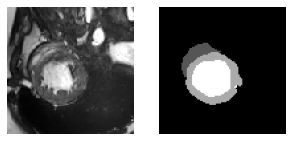

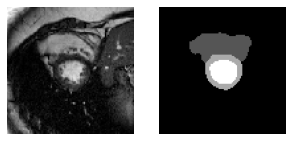

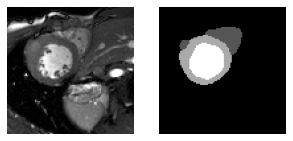

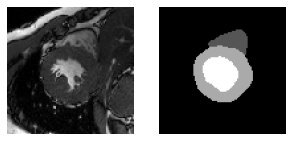

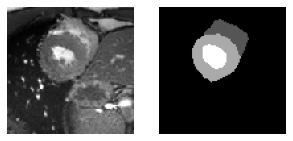

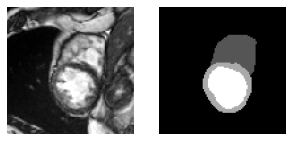

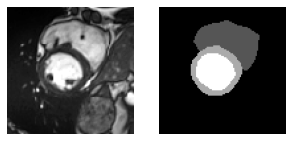

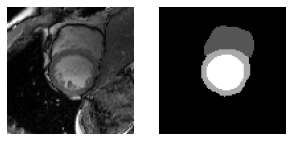

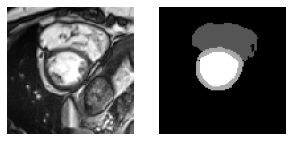

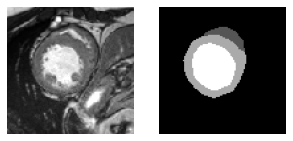

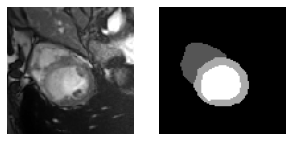

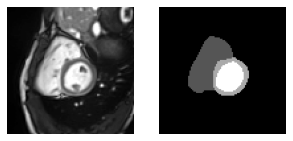

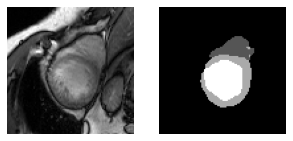

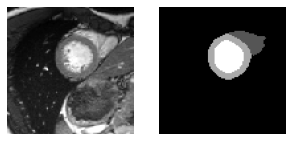

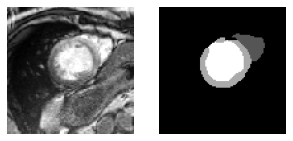

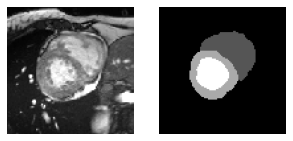

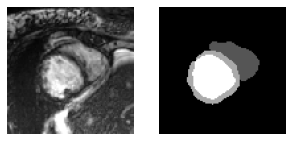

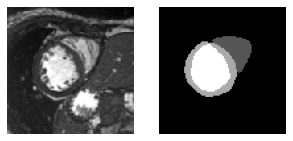

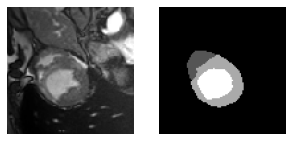

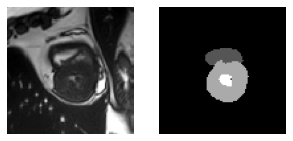

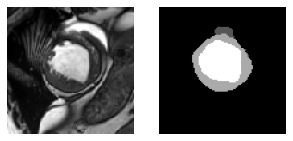

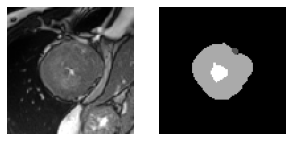

In [22]:
# Load final model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"The current device is {device}")

model=torch.load('./u-effb4.pth')
model.to(device)

model.eval()

input_test_data_path = '/content/drive/MyDrive/data/test/'
output_test_mask_path='/content/mask_EFFNET/'
num_workers = 4
batch_size = 1



test_set = TestDatasetModified(input_test_data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

    
for image,img_paths in test_data_loader:
        image = image.to(device)
        out = model(image)
        out_np = torch.max(out,1).indices.cpu().detach().numpy()
        image_np = image.cpu().detach().numpy()
        for i in range(batch_size):
            show_image_mask(image_np[i,0],out_np[i], cmap='gray')
            plt.pause(1)
            image_name = img_paths[i].split('/')[-1].split('.')[0]+'_mask.png'
            #print(image_name,os.path.join(output_test_mask_path,image_name))
            cv2.imwrite(os.path.join(output_test_mask_path,image_name),out_np[0])

# References

Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-Net: Convolutional Networks for Biomedical Image Segmentation URL: https://link.springer.com/content/pdf/10.1007/978-3-319-24574-4_28.pdf accessed on Nov 20,2021
URL: https://github.com/qubvel/segmentation_models.pytorch accessed on Nov 26,2021
URL: https://github.com/albumentations-team/albumentations accessed on Nov 27,2021
URL: https://smp.readthedocs.io/en/latest/losses.html#diceloss accessed on Nov 12,2021

Buslaev, A.; Iglovikov, V.I.; Khvedchenya, E.; Parinov, A.; Druzhinin, M.; Kalinin, A.A. Albumentations: Fast and Flexible Image Augmentations. Information 2020, 11, 125. https://doi.org/10.3390/info11020125

Ronneberger, O., Fischer, P., & Brox, T. (2015, October). U-net: Convolutional networks for biomedical image segmentation. In International Conference on Medical image computing and computer-assisted intervention (pp. 234-241). Springer, Cham.

Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. 2017. ImageNet classification with deep convolutional neural networks. Commun. ACM 60, 6 (June 2017), 84–90. DOI:https://doi.org/10.1145/3065386

Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). Imagenet classification with deep convolutional neural networks. Advances in neural information processing systems, 25, 1097-1105.

Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.

LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. nature, 521(7553), 436-444.

Tan, M., & Le, Q. (2019, May). Efficientnet: Rethinking model scaling for convolutional neural networks. In International Conference on Machine Learning (pp. 6105-6114). PMLR.

He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 770-778).

URL: https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47 accessed on Nov 15,2021

URL: https://towardsdatascience.com/4-pre-trained-cnn-models-to-use-for-computer-vision-with-transfer-learning-885cb1b2dfc accessed on Nov 26,2021

URL: https://github.com/usuyama/pytorch-unet accessed on Nov 19,2021
URL: https://www.analyticsvidhya.com/blog/2021/03/introduction-to-batch-normalization/ accessed on Nov 24,2021
URL: https://cs231n.github.io/transfer-learning/ acccessed on Nov 26,2021